In [ ]:
import networkx as nx
import random
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import openpyxl
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows

def draw_graph(graph, dominating_set):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Get the positions of the nodes
    pos = nx.spring_layout(graph)

    # Draw the nodes of the graph
    nx.draw_networkx_nodes(graph, pos, nodelist=set(graph.nodes()) - set(dominating_set), node_color='blue', ax=ax)
    nx.draw_networkx_nodes(graph, pos, nodelist=dominating_set, node_color='red', ax=ax)

    # Draw the edges of the graph
    nx.draw_networkx_edges(graph, pos, ax=ax)

    # Draw the labels of the nodes
    nx.draw_networkx_labels(graph, pos, ax=ax)

    # Display the graph
    plt.show()



def generate_graph():
    # Create an empty graph
    graph = nx.Graph()

    # Add nodes to the graph
    for node in range(ord('A'), ord('I')+1):
        graph.add_node(chr(node))

    # Add edges to the graph to form a complete graph
    for node1 in graph.nodes:
        for node2 in graph.nodes:
            if node1 != node2:
                # Add an edge with a random spreading factor between 7 and 12
                graph.add_edge(node1, node2, spreading_factor=random.randint(7, 12))

    # Generate a minimum spanning tree from the complete graph
    tree = nx.minimum_spanning_tree(graph, weight='spreading_factor')

    # Add some random edges to the tree to introduce cycles
    edges = list(graph.edges)
    random.shuffle(edges)
    for edge in edges:
        if edge not in tree.edges:
            tree.add_edge(*edge, spreading_factor=graph.edges[edge]['spreading_factor'])
            if nx.is_connected(tree):
                break

    return tree

def create_empty_schedule(num_channels, num_time_slots):
    # Create an empty schedule with the given number of channels and time slots
    schedule = [['' for _ in range(num_time_slots)] for _ in range(num_channels)]
    return schedule

def modify_schedule(schedule, channel, time_slot, value):
    # Modify the given time slot in the given channel with the given value
    schedule[channel][time_slot] = value
    return schedule


def compute_dominating_set(graph):
    # Compute a dominating set for the graph
    dominating_set = nx.dominating_set(graph)
    return dominating_set

def list_transmissions(graph, dominating_set):
    transmissions = {}

    # For each node in the dominating set
    for node in dominating_set:
        # Use BFS to find all 2nd-hop neighbors
        bfs_tree = nx.bfs_tree(graph, node, depth_limit=2)
        neighbors = list(bfs_tree.nodes)

        # Initialize the list of transmissions for the current node
        transmissions[node] = []

        # Add transmissions from the node to its direct neighbors
        for neighbor in graph.neighbors(node):
            transmissions[node].append({
                'source': node,
                'destination': neighbor,
                'spreading_factor': graph.edges[node, neighbor]['spreading_factor']
            })

        # For each neighbor
        for neighbor in neighbors:
            # If the neighbor is not the node itself
            if neighbor != node:
                # For each neighbor of the neighbor
                for neighbor_of_neighbor in graph.neighbors(neighbor):
                    # If the neighbor of the neighbor is in the BFS tree
                    if neighbor_of_neighbor in neighbors:
                        # Add the transmission to the list
                        transmissions[node].append({
                            'source': neighbor,
                            'destination': neighbor_of_neighbor,
                            'spreading_factor': graph.edges[neighbor, neighbor_of_neighbor]['spreading_factor']
                        })

        # Sort the transmissions by SF in descending order
        transmissions[node].sort(key=lambda x: x['spreading_factor'], reverse=True)

        # Reorder the transmissions so that paired transmissions are next to each other
        reordered_transmissions = []
        while transmissions[node]:
            transmission = transmissions[node].pop(0)
            reordered_transmissions.append(transmission)

            # Look for the pair of the current transmission
            for i, other_transmission in enumerate(transmissions[node]):
                if other_transmission['source'] == transmission['destination'] and other_transmission['destination'] == transmission['source']:
                    # If the pair is found, remove it from the list and add it to the reordered list
                    reordered_transmissions.append(transmissions[node].pop(i))
                    break

        transmissions[node] = reordered_transmissions

    return transmissions



def list_known_dominators(graph, dominating_set):
    known_dominators = {}

    # For each node in the dominating set
    for node in dominating_set:
        # Use BFS to find all 2nd-hop neighbors
        neighbors = nx.bfs_tree(graph, node, depth_limit=2).nodes

        # Initialize the list of known dominators for the current node
        known_dominators[node] = []

        # For each neighbor
        for neighbor in neighbors:
            # If the neighbor is a dominator
            if neighbor in dominating_set and neighbor!=node:
                # Add the dominator to the list
                known_dominators[node].append(neighbor)

    return known_dominators



def channel_list(transmissions, node, known_dominators):

    # Sort the transmissions by SF in descending order
    transmissions[node].sort(key=lambda x: x['spreading_factor'], reverse=True)


    # Initialize the list of channels for the current node
    C_list = [[], [None]]

    # Initialize the channel for transmissions involving the current node
    channel_self = []

    # Initialize the channel for transmissions that don't involve any dominator nodes
    channel_no_dominator = []

    # Initialize the channels for transmissions involving known dominator nodes
    channels_known_dominator = {dominator: [] for dominator in known_dominators[node]}

    # For each transmission
    for transmission in transmissions[node]:
        # If 2 dominant neighbors nodes other than itself are involved
        if (transmission['destination'] in known_dominators[node] and transmission['destination'] != node) and (transmission['source'] in known_dominators[node] and transmission['source'] != node):
            # Compare the ids of these neighbors
            if transmission['source'] < transmission['destination']:
                channels_known_dominator[transmission['source']].append(transmission)
            else:
                channels_known_dominator[transmission['destination']].append(transmission)

        # If the transmission involves the current node and another dominator node
        elif (transmission['source'] == node and transmission['destination'] in known_dominators[node]) or (transmission['destination'] == node and transmission['source'] in known_dominators[node]):
            if node < transmission['source'] or node < transmission['destination']:
                channel_self.append(transmission)
            else:
                if transmission['source'] != node:
                    channels_known_dominator[transmission['source']].append(transmission)
                elif transmission['destination'] != node:
                    channels_known_dominator[transmission['destination']].append(transmission)

        # If the transmission involves the current node and a classic node
        elif transmission['source'] == node or transmission['destination'] == node:
            channel_self.append(transmission)
        # If the transmission involves a dominant node and a classic node
        elif transmission['source'] in known_dominators[node] and transmission['destination'] not in known_dominators[node]:
          channels_known_dominator[transmission['source']].append(transmission)
        elif transmission['destination'] in known_dominators[node] and transmission['source'] not in known_dominators[node]:
          channels_known_dominator[transmission['destination']].append(transmission)

        # If the transmission doesn't involve any dominator nodes
        else:
            channel_no_dominator.append(transmission)

    # Add the channels to the list of channels
    C_list[0] = channel_self
    C_list[1] = channel_no_dominator
    for channel in channels_known_dominator.values():  # This list must be ordered in increasing ids
        C_list.append(channel)

    return C_list

'''
def check_collision(schedule, time_slot, duration, source, destination):
    for channel_index, transmissions in schedule.items():
        for transmission in transmissions:
            ts = transmission['time_slot']
            tr_duration = 2 ** (transmission['transmission']['spreading_factor'] - 7)
            if (ts < time_slot + duration and ts + tr_duration > time_slot) and \
                    (transmission['transmission']['source'] in [source, destination] or
                     transmission['transmission']['destination'] in [source, destination]):
                return True
    return False
'''
def check_collision(schedule, time_slot, duration, source, destination, exclude_channel=None):
    for channel_index, transmissions in schedule.items():
        if exclude_channel is not None and channel_index == exclude_channel:
            continue
        for transmission in transmissions:
            ts = transmission['time_slot']
            tr_duration = 2 ** (transmission['transmission']['spreading_factor'] - 7)
            if (ts < time_slot + duration and ts + tr_duration > time_slot) and \
                    (transmission['transmission']['source'] in [source, destination] or
                     transmission['transmission']['destination'] in [source, destination]):
                return True
    return False


def schedule_transmissions(node, node_channel_list):
    # Initialize the schedule
    schedule = {}

    # Initialize the next available time slot for each channel
    next_available_slot = [0] * len(node_channel_list)

    # For each channel
    for channel_index, channel in enumerate(node_channel_list):
        # For each transmission in the channel
        for transmission in channel:
            # The number of time slots needed is 2^(SF-7)
            num_time_slots = 2 ** (transmission['spreading_factor'] - 7)
            source = transmission['source']
            destination = transmission['destination']

            # Check if the transmission can be added to the schedule
            while check_collision(schedule, next_available_slot[channel_index], num_time_slots, source, destination):
                next_available_slot[channel_index] += 1

            # Add the transmission to the schedule
            if channel_index not in schedule:
                schedule[channel_index] = []
            schedule[channel_index].append({
                'time_slot': next_available_slot[channel_index],
                'transmission': transmission
            })

            # Update the next available time slot for the channel
            next_available_slot[channel_index] += num_time_slots

    return schedule


'''
def schedule_transmissions(node, node_channel_list):
    # Initialize the schedule
    schedule = {}

    # Initialize the next available time slot for each channel
    next_available_slot = [0] * len(node_channel_list)

    # For each channel
    i = 0
    while i < len(node_channel_list):
        channel_index = i
        channel = node_channel_list[i]
        # For each transmission in the channel
        j = 0
        while j < len(channel):
            transmission = channel[j]

            # The number of time slots needed is 2^(SF-7)
            num_time_slots = 2 ** (transmission['spreading_factor'] - 7)

            # Check if the transmission can be added to the schedule
            can_add_transmission = False
            while not can_add_transmission:
                can_add_transmission = True
                for other_channel_index, other_channel in enumerate(node_channel_list):
                    if other_channel_index != channel_index:
                        for other_transmission in schedule.get(other_channel_index, []):
                            if other_transmission['time_slot'] < next_available_slot[channel_index] + num_time_slots and other_transmission['time_slot'] + 2 ** (other_transmission['transmission']['spreading_factor'] - 7) > next_available_slot[channel_index] and (other_transmission['transmission']['source'] == transmission['source'] or other_transmission['transmission']['destination'] == transmission['destination'] or other_transmission['transmission']['source'] == transmission['destination'] or other_transmission['transmission']['destination'] == transmission['source']):
                                can_add_transmission = False
                                next_available_slot[channel_index] = other_transmission['time_slot'] + 2 ** (other_transmission['transmission']['spreading_factor'] - 7)  # Update to the end of the conflicting transmission
                                break
                    if not can_add_transmission:
                        break

            # Add the transmission to the schedule
            if channel_index not in schedule:
                schedule[channel_index] = []
            schedule[channel_index].append({
                'time_slot': next_available_slot[channel_index],
                'transmission': transmission
            })

            # Update the next available time slot for the channel
            next_available_slot[channel_index] += num_time_slots

            # If the next transmission is the pair of the current transmission, add it to the schedule
            if j + 1 < len(channel) and channel[j + 1]['source'] == transmission['destination'] and channel[j + 1]['destination'] == transmission['source']:
                schedule[channel_index].append({
                    'time_slot': next_available_slot[channel_index],
                    'transmission': channel[j + 1]
                })
                next_available_slot[channel_index] += num_time_slots
                j += 1  # Increment j after adding the paired transmission

            j += 1
        i += 1

    return schedule
'''







def visualize_schedule(schedule, total_channels):
    # Create a new figure
    fig = plt.figure()


    # Find the maximum time slot across all channels
    max_time_slot = max(max(transmission['time_slot'] + 2 ** (transmission['transmission']['spreading_factor'] - 7) for transmission in transmissions) for transmissions in schedule.values() if transmissions) if schedule else 0

    # For each channel
    for channel in range(total_channels):
        # Create a new subplot for the channel
        ax = fig.add_subplot(total_channels, 1, channel + 1)

        # If there are transmissions scheduled for the current channel
        if channel in schedule:
            # For each transmission in the channel
            for transmission in schedule[channel]:
                # Calculate the start, end, and duration of the transmission
                start = transmission['time_slot']
                duration = 2 ** (transmission['transmission']['spreading_factor'] - 7)

                # Create a rectangle for the transmission
                rect = patches.Rectangle((start, 0), duration, 1, facecolor=plt.cm.get_cmap('hsv')(channel / total_channels))

                # Add the rectangle to the subplot
                ax.add_patch(rect)

                # Add a label to the rectangle
                ax.text(start, 0.5, f"{transmission['transmission']['source']}-{transmission['transmission']['destination']}", verticalalignment='center')

        # Set the limits of the subplot
        ax.set_xlim(0, max_time_slot)
        ax.set_ylim(0, 1)

        # Set the labels of the subplot
        ax.set_xlabel('Time slot')
        ax.set_ylabel('Channel')

    # Display the figure
    plt.show()



def is_duplicate(primary_schedule, transmission):
    for channel_index, transmissions in primary_schedule.items():
        for existing_transmission in transmissions:
            if existing_transmission['transmission'] == transmission['transmission']:
                return True
    return False


def merge_schedules(primary_schedule, secondary_schedule):
    # List to keep track of the next available time slot for each channel
    next_available_slot = {}

    # Calculate the next available time slot for each channel in the primary schedule
    for channel_index, transmissions in primary_schedule.items():
        max_time_slot = max([trans['time_slot'] + 2 ** (trans['transmission']['spreading_factor'] - 7) for trans in transmissions])
        next_available_slot[channel_index] = max_time_slot

    # Remove duplicates from secondary schedule by creating a modified version
    modified_secondary_schedule = {}
    for channel_index, transmissions in secondary_schedule.items():
        modified_transmissions = []
        for transmission in transmissions:
            if not is_duplicate(primary_schedule, transmission):
                modified_transmissions.append(transmission)
        modified_secondary_schedule[channel_index] = modified_transmissions

    # Iterate through the transmissions of the modified secondary schedule
    for channel_index, transmissions in modified_secondary_schedule.items():
        for transmission in transmissions:

            # Find a suitable time slot in the primary schedule for this transmission
            num_time_slots = 2 ** (transmission['transmission']['spreading_factor'] - 7)
            source = transmission['transmission']['source']
            destination = transmission['transmission']['destination']
            while check_collision(primary_schedule, next_available_slot.get(channel_index, 0), num_time_slots, source, destination):
                next_available_slot[channel_index] = next_available_slot.get(channel_index, 0) + 1

            # Add the transmission to the primary schedule
            if channel_index not in primary_schedule:
                primary_schedule[channel_index] = []
            primary_schedule[channel_index].append({
                'time_slot': next_available_slot.get(channel_index, 0),
                'transmission': transmission['transmission']
            })

            # Update the next available time slot for the channel
            next_available_slot[channel_index] = next_available_slot.get(channel_index, 0) + num_time_slots

    return primary_schedule


def time_slot_occupied(channel, time_slot, duration):
    for transmission in channel:
        ts = transmission['time_slot']
        tr_duration = 2 ** (transmission['transmission']['spreading_factor'] - 7)
        if ts < time_slot + duration and ts + tr_duration > time_slot:
            return True
    return False


def optimize_schedule(schedule):
    # Get the list of channel indices in descending order
    channel_indices = sorted(schedule.keys(), reverse=True)

    # Iterate through the channels in reverse order
    for channel_index in channel_indices:
        # Keep a list of transmissions to be removed
        to_remove = []

        # Iterate through the transmissions in this channel
        for transmission in schedule[channel_index]:
            time_slot = transmission['time_slot']
            duration = 2 ** (transmission['transmission']['spreading_factor'] - 7)
            source = transmission['transmission']['source']
            destination = transmission['transmission']['destination']

            # Check if this transmission can be moved to an earlier channel
            moved = False
            for earlier_channel_index in range(channel_index):
                if not check_collision(schedule, time_slot, duration, source, destination, exclude_channel=channel_index) and not time_slot_occupied(schedule.get(earlier_channel_index, []), time_slot, duration):
                    # Add to the earliest channel where it can be placed
                    if earlier_channel_index not in schedule:
                        schedule[earlier_channel_index] = []
                    schedule[earlier_channel_index].append(transmission)
                    to_remove.append(transmission)
                    moved = True
                    break

        # Remove the transmissions that have been moved to earlier channels
        for transmission in to_remove:
            schedule[channel_index].remove(transmission)

        # Remove the channel if it has no transmissions
        if not schedule[channel_index]:
            del schedule[channel_index]

    return schedule



def merge_schedules4(schedule1, schedule2, node1, node2):
    # Initialize the merged schedule
    merged_schedule = {}

    # Determine which node has the smaller id
    if node1 < node2:
        self_node = node1
        other_node = node2
    else:
        self_node = node2
        other_node = node1

    # Merge the channels from the first schedule
    for channel, transmissions in schedule1.items():
        if channel == 0:  # "self" channel
            if self_node == node1:  # If the first node is the self node
                # Merge the "self" channel of the first schedule with the corresponding "known dominant node channel" of the second schedule
                merged_schedule[channel] = sorted(transmissions + schedule2.get(other_node, []), key=lambda x: (x['time_slot'], x['transmission']['source'], x['transmission']['destination']))
            else:  # If the second node is the self node
                # Add the "self" channel to the merged schedule
                merged_schedule[channel] = transmissions
        elif channel in schedule2 and channel != other_node:
            # Merge the two channels
            merged_schedule[channel] = sorted(transmissions + schedule2[channel], key=lambda x: (x['time_slot'], x['transmission']['source'], x['transmission']['destination']))
        else:
            # Add the channel to the merged schedule
            merged_schedule[channel] = transmissions

    # Add the channels from the second schedule that don't have a corresponding channel in the first schedule
    for channel, transmissions in schedule2.items():
        if channel not in merged_schedule and channel != other_node:
            merged_schedule[channel] = transmissions

    # Remove duplicate transmissions
    for channel, transmissions in merged_schedule.items():
        seen = set()
        merged_schedule[channel] = [x for x in transmissions if not (frozenset(x['transmission'].items()) in seen or seen.add(frozenset(x['transmission'].items())))]
        merged_schedule[channel] = [dict(x) for x in merged_schedule[channel]]

    # Initialize end times for each transmission
    for channel, transmissions in merged_schedule.items():
        for transmission in transmissions:
            transmission['end_time'] = transmission['time_slot'] + 2 ** (transmission['transmission']['spreading_factor'] - 7)

    # Resolve conflicts
    for channel, transmissions in merged_schedule.items():
        # Sort by start time, then by end time
        merged_schedule[channel] = sorted(transmissions, key=lambda x: (x['time_slot'], x['end_time']))
        i = 0
        while i < len(merged_schedule[channel]) - 1:
            transmission1 = merged_schedule[channel][i]
            transmission2 = merged_schedule[channel][i + 1]
            if transmission1['end_time'] > transmission2['time_slot']:
                # If conflict, delay the start and end time of the second transmission
                delay = transmission1['end_time'] - transmission2['time_slot']
                transmission2['time_slot'] += delay
                transmission2['end_time'] += delay
                # Sort the transmissions again since the order might have changed
                merged_schedule[channel] = sorted(merged_schedule[channel], key=lambda x: (x['time_slot'], x['end_time']))
            else:
                i += 1

    # Remove end_time from all transmissions, as it's not part of the original structure
    for channel, transmissions in merged_schedule.items():
        for transmission in transmissions:
            del transmission['end_time']

    return merged_schedule



def adjust_schedule(primary_schedule, secondary_schedule):
    adjusted_schedule = secondary_schedule.copy()

    for channel, transmissions in primary_schedule.items():
        for primary_transmission in transmissions:
            primary_start = primary_transmission['time_slot']
            primary_duration = 2 ** (primary_transmission['transmission']['spreading_factor'] - 7)

            # Check if the same channel exists in the secondary schedule
            if channel in adjusted_schedule:
                i = 0
                while i < len(adjusted_schedule[channel]):
                    secondary_transmission = adjusted_schedule[channel][i]
                    secondary_start = secondary_transmission['time_slot']
                    secondary_duration = 2 ** (secondary_transmission['transmission']['spreading_factor'] - 7)

                    # Check for overlap
                    if not (secondary_start + secondary_duration <= primary_start or
                            secondary_start >= primary_start + primary_duration):

                        # Move the secondary transmission to after the primary one
                        secondary_transmission['time_slot'] = primary_start + primary_duration

                        # Resort the transmissions in the current channel based on the new time slot
                        adjusted_schedule[channel] = sorted(adjusted_schedule[channel], key=lambda x: x['time_slot'])
                        # Restart the loop to check for any new collisions after adjustment
                        i = 0
                    else:
                        i += 1
    return adjusted_schedule

def calculate_efficiency_score(schedule):
    # Count the total number of time slots used
    total_time_slots_used = 0

    # Count the total data transmitted
    total_data_transmitted = 0

    # Determine the maximum time slot used for calculating utilization
    max_time_slot = 0

    # Iterate through each channel in the schedule
    for channel, transmissions in schedule.items():
        # Count the transmissions in this channel
        for transmission in transmissions:
            # Count the data transmitted in this transmission
            spreading_factor = transmission['transmission']['spreading_factor']
            total_data_transmitted += 2 ** (spreading_factor - 7)

            # Count the time slots used for this transmission
            start_time_slot = transmission['time_slot']
            duration = 2 ** (spreading_factor - 7)
            total_time_slots_used += duration

            # Update the maximum time slot used
            max_time_slot = max(max_time_slot, start_time_slot + duration)

    # Calculate the total number of channels used
    total_channels_used = len(schedule)

    # Calculate utilization (percentage of timeslots used)
    total_time_slots_available = max_time_slot * total_channels_used
    utilization = (total_time_slots_used / total_time_slots_available) if total_time_slots_available > 0 else 0

    # Calculate throughput (total data transmitted per time slot)
    throughput = total_data_transmitted / total_time_slots_used if total_time_slots_used > 0 else 0

    # Calculate the efficiency score based on utilization and throughput
    # Here, both are given equal weightage, but you can adjust as needed
    efficiency_score = 0.5 * utilization + 0.5 * throughput

    return efficiency_score



In [ ]:
Network = generate_graph()







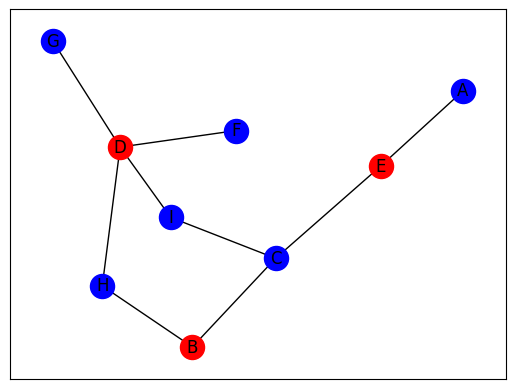

['D', 'E', 'B']
['B']
D [[{'source': 'D', 'destination': 'I', 'spreading_factor': 8}, {'source': 'I', 'destination': 'D', 'spreading_factor': 8}, {'source': 'D', 'destination': 'F', 'spreading_factor': 7}, {'source': 'F', 'destination': 'D', 'spreading_factor': 7}, {'source': 'D', 'destination': 'G', 'spreading_factor': 7}, {'source': 'G', 'destination': 'D', 'spreading_factor': 7}, {'source': 'D', 'destination': 'H', 'spreading_factor': 7}, {'source': 'H', 'destination': 'D', 'spreading_factor': 7}], [{'source': 'I', 'destination': 'C', 'spreading_factor': 7}, {'source': 'C', 'destination': 'I', 'spreading_factor': 7}], [{'source': 'B', 'destination': 'C', 'spreading_factor': 8}, {'source': 'C', 'destination': 'B', 'spreading_factor': 8}, {'source': 'H', 'destination': 'B', 'spreading_factor': 7}, {'source': 'B', 'destination': 'H', 'spreading_factor': 7}]]
{0: [{'time_slot': 0, 'transmission': {'source': 'D', 'destination': 'I', 'spreading_factor': 8}}, {'time_slot': 2, 'transmission

<ipython-input-29-222794a06d82>:365: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rect = patches.Rectangle((start, 0), duration, 1, facecolor=plt.cm.get_cmap('hsv')(channel / total_channels))


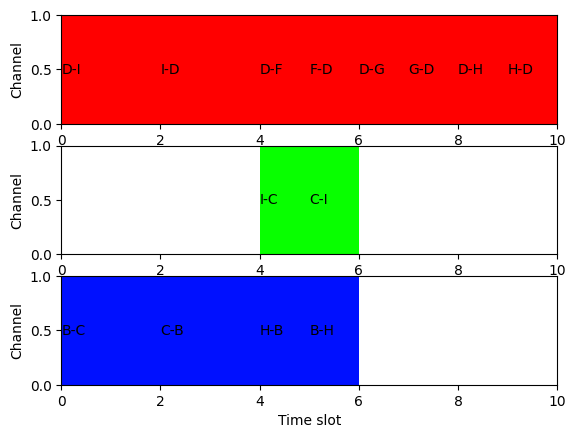

['B']
E [[{'source': 'E', 'destination': 'A', 'spreading_factor': 7}, {'source': 'A', 'destination': 'E', 'spreading_factor': 7}, {'source': 'E', 'destination': 'C', 'spreading_factor': 7}, {'source': 'C', 'destination': 'E', 'spreading_factor': 7}], [{'source': 'C', 'destination': 'I', 'spreading_factor': 7}, {'source': 'I', 'destination': 'C', 'spreading_factor': 7}], [{'source': 'C', 'destination': 'B', 'spreading_factor': 8}, {'source': 'B', 'destination': 'C', 'spreading_factor': 8}]]
{0: [{'time_slot': 0, 'transmission': {'source': 'E', 'destination': 'A', 'spreading_factor': 7}}, {'time_slot': 1, 'transmission': {'source': 'A', 'destination': 'E', 'spreading_factor': 7}}, {'time_slot': 2, 'transmission': {'source': 'E', 'destination': 'C', 'spreading_factor': 7}}, {'time_slot': 3, 'transmission': {'source': 'C', 'destination': 'E', 'spreading_factor': 7}}], 1: [{'time_slot': 0, 'transmission': {'source': 'C', 'destination': 'I', 'spreading_factor': 7}}, {'time_slot': 1, 'transmi

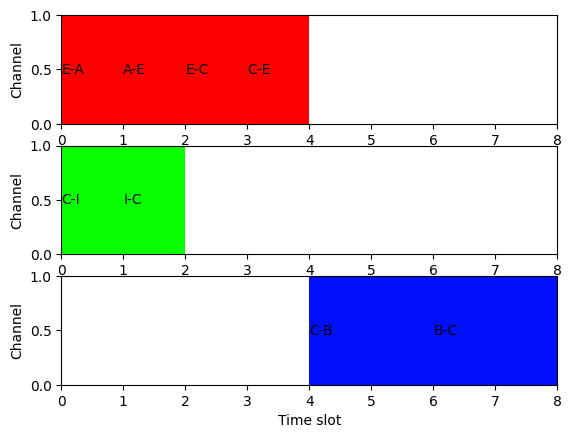

['D', 'E']
B [[{'source': 'B', 'destination': 'C', 'spreading_factor': 8}, {'source': 'C', 'destination': 'B', 'spreading_factor': 8}, {'source': 'B', 'destination': 'H', 'spreading_factor': 7}, {'source': 'H', 'destination': 'B', 'spreading_factor': 7}], [{'source': 'C', 'destination': 'I', 'spreading_factor': 7}, {'source': 'I', 'destination': 'C', 'spreading_factor': 7}], [{'source': 'D', 'destination': 'I', 'spreading_factor': 8}, {'source': 'I', 'destination': 'D', 'spreading_factor': 8}, {'source': 'H', 'destination': 'D', 'spreading_factor': 7}, {'source': 'D', 'destination': 'H', 'spreading_factor': 7}], [{'source': 'C', 'destination': 'E', 'spreading_factor': 7}, {'source': 'E', 'destination': 'C', 'spreading_factor': 7}]]
{0: [{'time_slot': 0, 'transmission': {'source': 'B', 'destination': 'C', 'spreading_factor': 8}}, {'time_slot': 2, 'transmission': {'source': 'C', 'destination': 'B', 'spreading_factor': 8}}, {'time_slot': 4, 'transmission': {'source': 'B', 'destination': '

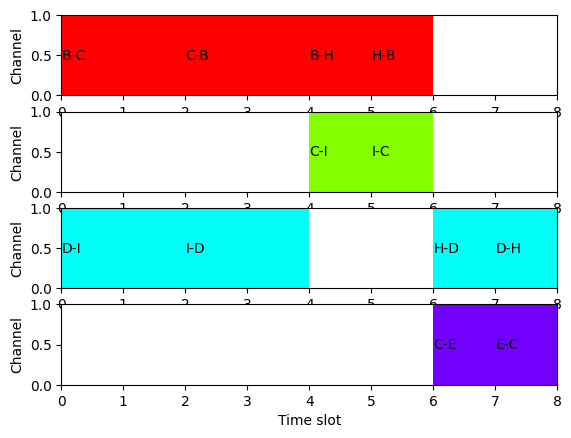

D   B
{0: [{'time_slot': 0, 'transmission': {'source': 'D', 'destination': 'I', 'spreading_factor': 8}}, {'time_slot': 2, 'transmission': {'source': 'I', 'destination': 'D', 'spreading_factor': 8}}, {'time_slot': 4, 'transmission': {'source': 'D', 'destination': 'F', 'spreading_factor': 7}}, {'time_slot': 5, 'transmission': {'source': 'F', 'destination': 'D', 'spreading_factor': 7}}, {'time_slot': 6, 'transmission': {'source': 'D', 'destination': 'G', 'spreading_factor': 7}}, {'time_slot': 7, 'transmission': {'source': 'G', 'destination': 'D', 'spreading_factor': 7}}, {'time_slot': 8, 'transmission': {'source': 'D', 'destination': 'H', 'spreading_factor': 7}}, {'time_slot': 9, 'transmission': {'source': 'H', 'destination': 'D', 'spreading_factor': 7}}], 1: [{'time_slot': 4, 'transmission': {'source': 'I', 'destination': 'C', 'spreading_factor': 7}}, {'time_slot': 5, 'transmission': {'source': 'C', 'destination': 'I', 'spreading_factor': 7}}], 2: [{'time_slot': 0, 'transmission': {'sour

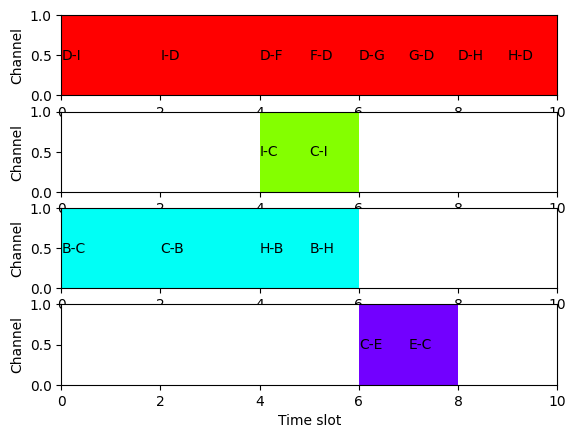

{0: [{'time_slot': 0, 'transmission': {'source': 'D', 'destination': 'I', 'spreading_factor': 8}}, {'time_slot': 2, 'transmission': {'source': 'I', 'destination': 'D', 'spreading_factor': 8}}, {'time_slot': 4, 'transmission': {'source': 'D', 'destination': 'F', 'spreading_factor': 7}}, {'time_slot': 5, 'transmission': {'source': 'F', 'destination': 'D', 'spreading_factor': 7}}, {'time_slot': 6, 'transmission': {'source': 'D', 'destination': 'G', 'spreading_factor': 7}}, {'time_slot': 7, 'transmission': {'source': 'G', 'destination': 'D', 'spreading_factor': 7}}, {'time_slot': 8, 'transmission': {'source': 'D', 'destination': 'H', 'spreading_factor': 7}}, {'time_slot': 9, 'transmission': {'source': 'H', 'destination': 'D', 'spreading_factor': 7}}], 1: [{'time_slot': 4, 'transmission': {'source': 'I', 'destination': 'C', 'spreading_factor': 7}}, {'time_slot': 5, 'transmission': {'source': 'C', 'destination': 'I', 'spreading_factor': 7}}, {'time_slot': 6, 'transmission': {'source': 'C', '

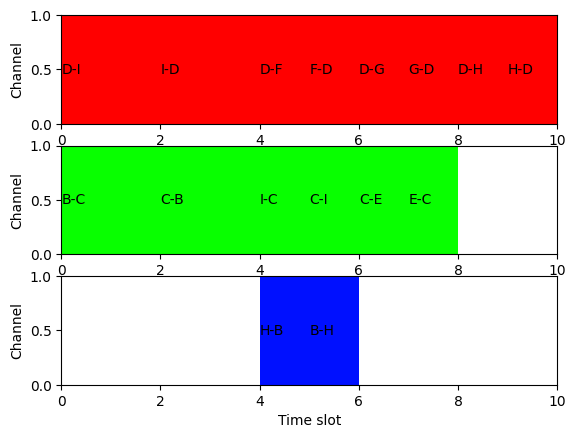

E   B
{0: [{'time_slot': 0, 'transmission': {'source': 'E', 'destination': 'A', 'spreading_factor': 7}}, {'time_slot': 1, 'transmission': {'source': 'A', 'destination': 'E', 'spreading_factor': 7}}, {'time_slot': 2, 'transmission': {'source': 'E', 'destination': 'C', 'spreading_factor': 7}}, {'time_slot': 3, 'transmission': {'source': 'C', 'destination': 'E', 'spreading_factor': 7}}, {'time_slot': 8, 'transmission': {'source': 'B', 'destination': 'H', 'spreading_factor': 7}}, {'time_slot': 9, 'transmission': {'source': 'H', 'destination': 'B', 'spreading_factor': 7}}], 1: [{'time_slot': 0, 'transmission': {'source': 'C', 'destination': 'I', 'spreading_factor': 7}}, {'time_slot': 1, 'transmission': {'source': 'I', 'destination': 'C', 'spreading_factor': 7}}], 2: [{'time_slot': 4, 'transmission': {'source': 'C', 'destination': 'B', 'spreading_factor': 8}}, {'time_slot': 6, 'transmission': {'source': 'B', 'destination': 'C', 'spreading_factor': 8}}, {'time_slot': 8, 'transmission': {'sour

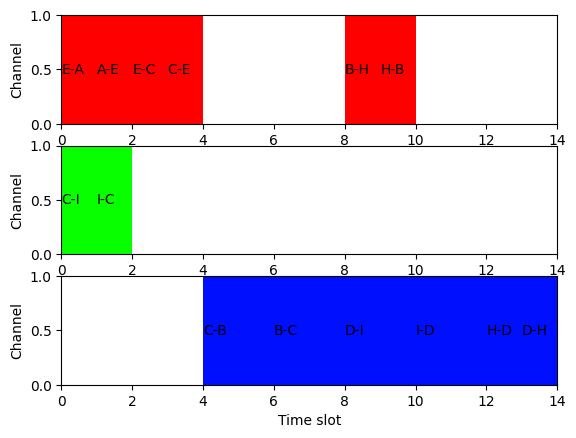

{0: [{'time_slot': 0, 'transmission': {'source': 'E', 'destination': 'A', 'spreading_factor': 7}}, {'time_slot': 1, 'transmission': {'source': 'A', 'destination': 'E', 'spreading_factor': 7}}, {'time_slot': 2, 'transmission': {'source': 'E', 'destination': 'C', 'spreading_factor': 7}}, {'time_slot': 3, 'transmission': {'source': 'C', 'destination': 'E', 'spreading_factor': 7}}, {'time_slot': 8, 'transmission': {'source': 'B', 'destination': 'H', 'spreading_factor': 7}}, {'time_slot': 9, 'transmission': {'source': 'H', 'destination': 'B', 'spreading_factor': 7}}, {'time_slot': 4, 'transmission': {'source': 'C', 'destination': 'B', 'spreading_factor': 8}}, {'time_slot': 6, 'transmission': {'source': 'B', 'destination': 'C', 'spreading_factor': 8}}, {'time_slot': 10, 'transmission': {'source': 'I', 'destination': 'D', 'spreading_factor': 8}}, {'time_slot': 12, 'transmission': {'source': 'H', 'destination': 'D', 'spreading_factor': 7}}, {'time_slot': 13, 'transmission': {'source': 'D', 'de

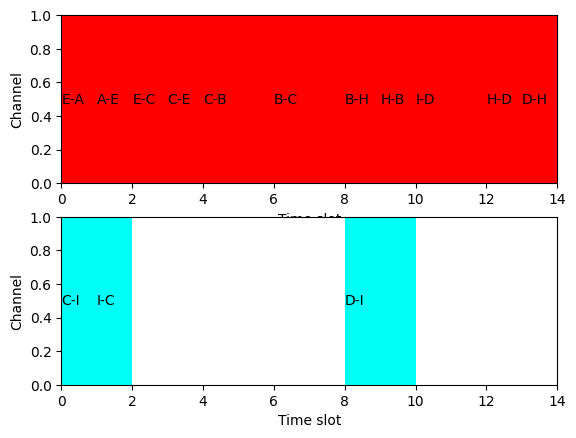

B   D
{0: [{'time_slot': 0, 'transmission': {'source': 'B', 'destination': 'C', 'spreading_factor': 8}}, {'time_slot': 2, 'transmission': {'source': 'C', 'destination': 'B', 'spreading_factor': 8}}, {'time_slot': 4, 'transmission': {'source': 'B', 'destination': 'H', 'spreading_factor': 7}}, {'time_slot': 5, 'transmission': {'source': 'H', 'destination': 'B', 'spreading_factor': 7}}, {'time_slot': 8, 'transmission': {'source': 'D', 'destination': 'F', 'spreading_factor': 7}}, {'time_slot': 9, 'transmission': {'source': 'F', 'destination': 'D', 'spreading_factor': 7}}, {'time_slot': 10, 'transmission': {'source': 'D', 'destination': 'G', 'spreading_factor': 7}}, {'time_slot': 11, 'transmission': {'source': 'G', 'destination': 'D', 'spreading_factor': 7}}], 1: [{'time_slot': 4, 'transmission': {'source': 'C', 'destination': 'I', 'spreading_factor': 7}}, {'time_slot': 5, 'transmission': {'source': 'I', 'destination': 'C', 'spreading_factor': 7}}], 2: [{'time_slot': 0, 'transmission': {'so

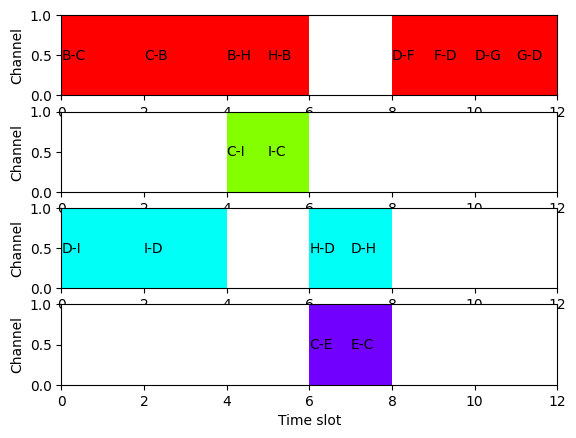

{0: [{'time_slot': 0, 'transmission': {'source': 'B', 'destination': 'C', 'spreading_factor': 8}}, {'time_slot': 2, 'transmission': {'source': 'C', 'destination': 'B', 'spreading_factor': 8}}, {'time_slot': 4, 'transmission': {'source': 'B', 'destination': 'H', 'spreading_factor': 7}}, {'time_slot': 5, 'transmission': {'source': 'H', 'destination': 'B', 'spreading_factor': 7}}, {'time_slot': 8, 'transmission': {'source': 'D', 'destination': 'F', 'spreading_factor': 7}}, {'time_slot': 9, 'transmission': {'source': 'F', 'destination': 'D', 'spreading_factor': 7}}, {'time_slot': 10, 'transmission': {'source': 'D', 'destination': 'G', 'spreading_factor': 7}}, {'time_slot': 11, 'transmission': {'source': 'G', 'destination': 'D', 'spreading_factor': 7}}, {'time_slot': 6, 'transmission': {'source': 'C', 'destination': 'E', 'spreading_factor': 7}}, {'time_slot': 7, 'transmission': {'source': 'E', 'destination': 'C', 'spreading_factor': 7}}], 1: [{'time_slot': 4, 'transmission': {'source': 'C',

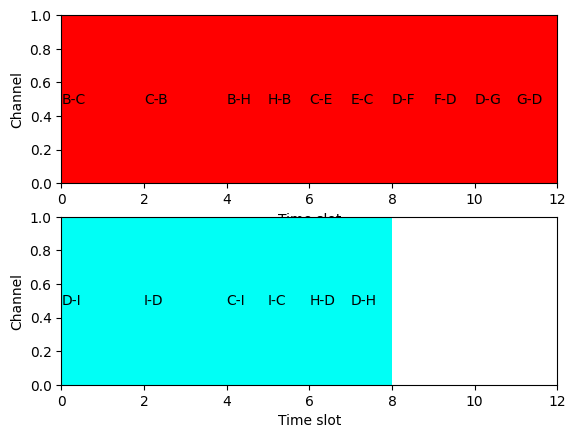

In [ ]:
Dom_set = list(compute_dominating_set(Network))
draw_graph(Network, Dom_set)
K_d = list_known_dominators(Network, Dom_set)
transmissions = list_transmissions(Network, Dom_set)
CLIST = []

print(Dom_set)

G_sch = []
Merged_sch=[]


for node in Dom_set:
  a=K_d[node]
  print(a)
  CLIST=channel_list(transmissions,node, K_d)
  print(node, CLIST)
  Schedule = schedule_transmissions(node,CLIST)
  G_sch.append(Schedule)
  score = calculate_efficiency_score(Schedule)
  print(Schedule)
  print(score)
  total_channels=len(Schedule)
  df=visualize_schedule(Schedule, total_channels)


for i in range(0,len(Dom_set)):
  a=K_d[Dom_set[i]]
  if len(a)>0:
    n_clist = channel_list(transmissions, a[0], K_d )
    neighbor_schedule = schedule_transmissions(a[0], n_clist)
    #Merged_sch = merge_schedules4(G_sch[i], neighbor_schedule, Dom_set[i], a[0])
    Merged_sch =merge_schedules(G_sch[i], neighbor_schedule)
    print(Dom_set[i]," ", a[0])
    print(Merged_sch)
    m_channels = len(Merged_sch)
    Mdf=visualize_schedule(Merged_sch, m_channels)

    Opt_sch = optimize_schedule(Merged_sch)
    o_channels = len(Opt_sch)
    print(Opt_sch)
    Opt = visualize_schedule(Opt_sch, o_channels)
